In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import time
import missingno as msno
import seaborn as sns
sns.set(style="whitegrid")

In [2]:
data = pd.read_csv('allStylesData.csv')
print(data.columns)

Index(['recipeURL', 'name', 'author', 'method', 'style', 'boilTime',
       'batchSize', 'preBoilSize', 'postBoilSize', 'preBoilGravity',
       'efficiency', 'source', 'noChill', 'rating', 'numRating', 'hopUtil',
       'calories', 'carbs', 'views', 'brews', 'links', 'dateCreated', 'og',
       'fg', 'abv', 'ibu', 'srm', 'mashPh', 'fermNames', 'fermAmounts',
       'fermPPGs', 'fermLs', 'fermBillPs', 'hopAmounts', 'hopNames',
       'hopForms', 'hopAAs', 'hopUses', 'hopTimes', 'hopIBUs', 'hopBillPs',
       'yeastNames', 'yeastAmounts', 'yeastAttenuations', 'yeastOptTemps',
       'yeastFlocs', 'yeastStarters', 'yeastFermTemps', 'yeastPitchRates',
       'ca', 'mg', 'na', 'cl', 'so4', 'hco3', 'twNotes', 'priming',
       'otherNames', 'otherAmounts', 'otherTypes', 'otherUses', 'otherTimes',
       'mashAmounts', 'mashDescs', 'mashTypes', 'mashTemps', 'mashTimes',
       'mashThick', 'notes'],
      dtype='object')


In [3]:
#drop columns that are not useful to classification (ignoring water profile as well for now)
data = data.drop(columns=['recipeURL','name','author','method','source','noChill','rating',
                          'numRating','views','brews','links','dateCreated',
                          'twNotes','notes','ca','mg','na','cl','so4','hco3','priming','notes'])

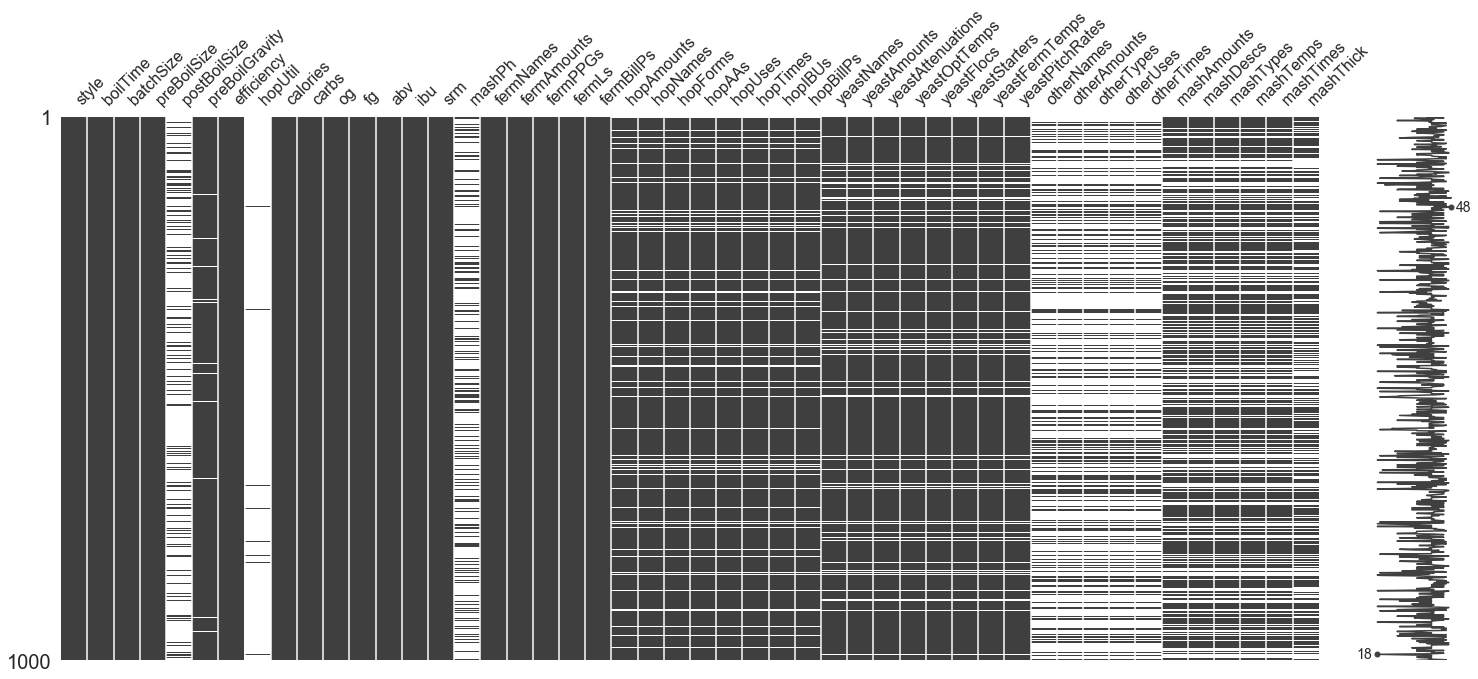

In [13]:
msno.matrix(data.sample(1000))

In [4]:
#drop columns that are mostly NA and most mash info because its not consistent
#and as reliable as the other features
data = data.drop(columns=['postBoilSize','hopUtil','mashPh','mashAmounts',
                         'mashDescs','mashTypes','mashTemps','mashTimes'])

# Ingredient cleaning

In [5]:
def get_ingr_counts(ingrSeries, ingrName):
    #get list of ingredients used (contains repeats)
    ingrList = []
    #ingrSeries = ingrSeries.fillna('NA')

    #for each recipe, turn string of all ingredients into a list and add it to list of all fermentables used
    #this method assumes that each ingredient is only present once in each recipe
#     for i in range(0,len(ingrSeries)):
#         test_string = ingrSeries[i]
#         tempType = re.findall(r'\'(.*?)\'', test_string)
#         resType = list(map(str, tempType))    
#         ingrList.append(resType)
        
    ingrList = []
    #ingrSeries = ingrSeries.fillna('NA')
    for i in range(0,len(ingrSeries)):
        ingr_str = ingrSeries[i]
        raw_ingr_list = str(ingr_str).split(',')
        cleaned_ingr_list = []
        for raw_ingr in raw_ingr_list:
            #replace non-letters/numbers & apostrophe ([^0-9a-zA-Z' ]+) with '' (nothing).
            clean_ingr = re.sub('[^0-9a-zA-Z" ]+', '', raw_ingr) #need to keep numbers!@#@$#$^%#$%^%$#
            clean_ingr = re.sub("[^0-9a-zA-Z' ]+", '', clean_ingr).strip()
            cleaned_ingr_list.append(clean_ingr)
            
        ingrList.append(cleaned_ingr_list)

    #create comprehensive list of unique hops used
    uniqueIngr = []
    for ingrs in ingrList:
        for ingr in ingrs:    
            if ingr not in uniqueIngr:
                uniqueIngr.append(ingr)

    print('Number of unique '+ingrName+': ', len(uniqueIngr)) 

    #find number of recipes that each unique grain is used in.
    uniqueIngrCount = [0]*len(uniqueIngr)

    for i in range(0,len(ingrList)):
        for j in range(0,len(set(ingrList[i]))): #use set() to get set of hops for each recipe i.e set([1,1,2,2,3]) = [1,2,3]
            if ingrList[i][j] in uniqueIngr:
                uniqueIngrCount[uniqueIngr.index(ingrList[i][j])] = uniqueIngrCount[uniqueIngr.index(ingrList[i][j])]+1          

    ingr_df = pd.DataFrame({ingrName:uniqueIngr,'Count':uniqueIngrCount})
    ingr_df = ingr_df.sort_values('Count',ascending = False).reset_index(drop=True)
    
    return ingr_df

In [21]:
#by forcing all characters to lowercase, we can reduce the number of unique ingredients significantly,
#849 less for hops, 291 less for ferms, and 2221 less for others
hops = [str(hopList).lower() for hopList in data.hopNames]
ferms = [str(fermList).lower() for fermList in data.fermNames]
others = [str(otherList).lower() for otherList in data.otherNames]
yeasts = [str(yeastList).lower() for yeastList in data.yeastNames]

hopCount = get_ingr_counts(hops, 'Hops')
fermCount = get_ingr_counts(ferms, 'Fermentables')
otherCount = get_ingr_counts(others, 'Others')
yeastCount = get_ingr_counts(yeasts, 'Yeasts')
dfCount = pd.concat([hopCount,fermCount,otherCount,yeastCount],axis=1)

Number of unique Hops :  3610
Number of unique Fermentables :  5176
Number of unique Others :  8924
Number of unique Yeasts :  2116


In [6]:
hop_data = pd.read_csv('hop_info.csv')
ferm_data = pd.read_csv('ferm_info.csv')
other_data = pd.read_csv('other_info.csv')
yeast_data = pd.read_csv('yeast_info.csv')

print('Total Hops:',len(hop_data))
print('Total ferms:',len(ferm_data))
print('Total others:',len(other_data))
print('Total yeasts:',len(yeast_data))

Total Hops: 438
Total ferms: 845
Total others: 1593
Total yeasts: 576


Compared to the lists of ingredients brewersfriend provides, we can see our dataset contains
many more (4-6x). This is mainly just a result of typos when users input recipes as previously shown in
the EDA script. We will remedy this by converting the ingredient strings in our dataset to ones that are
most similar to the ones that are provided by brewersfriend. 
i.e., turn each of the following: 'cuitra', 'cirtra', 'ciitra' into the correct hop: 'citra'

### 1) Hops

In [ ]:
#we'll focus on the first 133 hops (the remaining are mostly the same except theyre just preceeded by brand name)

#lets try using levenshtein distance to further reduce total number of unique ingredients
from difflib import get_close_matches
  
possibleMatches = []
finalPossibleMatches = []
for i in range(0,len(hopCount.Hops)):
    possibleMatches.append(get_close_matches(hopCount.Hops[i],hopCount.Hops[i:],n=25,cutoff=0.90))
    if len(possibleMatches[i]) > 1:
        finalPossibleMatches.append(possibleMatches[i])


print('Total Possible Matches: ' + str(len(finalPossibleMatches)))          
print(finalPossibleMatches[0:10])

In [7]:
#need to fix regex see hopNames[521]: falconer's... 
def convert_to_ingr_list(ingrSeries):
    ingrList = []
    ingrSeries = ingrSeries.fillna('NA')
    for i in range(0,len(ingrSeries)):
        ingr_str = ingrSeries[i]
        raw_ingr_list = ingr_str.split(',')
        cleaned_ingr_list = []
        for raw_ingr in raw_ingr_list:
            #replace non-letters/numbers & apostrophe ([^0-9a-zA-Z' ]+) with '' (nothing).
            clean_ingr = re.sub('[^0-9a-zA-Z" ]+', '', raw_ingr) 
            clean_ingr = re.sub("[^0-9a-zA-Z' ]+", '', clean_ingr).strip()
            cleaned_ingr_list.append(clean_ingr)
            
        ingrList.append(cleaned_ingr_list)
    
    return ingrList

In [9]:
hopNames = convert_to_ingr_list(data.hopNames)
print(hopNames[0])
print(hopNames[521][0])



['Chinook', 'Citra', 'Mosaic', 'Citra', 'Mosaic', 'Chinook', 'Citra', 'Mosaic']
Falconers Flight


In [11]:
print(hopNames[0])
print(hopNames[521])

['Chinook', 'Citra', 'Mosaic', 'Citra', 'Mosaic', 'Chinook', 'Citra', 'Mosaic']
['Falconers Flight', 'Northern Brewer', 'Simcoe', 'Citra']


In [28]:
#need to replace " " with ' ' - happens to ingr names that weren't hyperlinked. 
#affects the convert_ingr_to _list function

from fuzzywuzzy import fuzz
from fuzzywuzzy import process

start_time = time.time()

hopOptions = [hop.lower() for hop in hop_data.hop[0:133]]
finalHopsCleaned = []
for hops in hopNames:
    cleanedHops = []
    for hop in hops:
        highest = process.extractOne(hop.lower(),hopOptions)
        if highest[1] > 0.94:
            cleanedHop = highest[0]
        else:
            cleanedHop = hop
        
        cleanedHops.append(cleanedHop)
    
    finalHopsCleaned.append(cleanedHops) 

print("--- %s seconds ---" % (time.time() - start_time))
    
#NOTE hops at index 1528 use foreign language so input string is reduced to empty string

--- 8813.451257705688 seconds ---


In [36]:
# df = pd.DataFrame({'cleanedHops':finalHopsCleaned})
# df.to_csv('cleanedHops.csv', encoding = 'utf-8', index = False)

In [65]:
print(len(finalHopsCleaned))
hops = [str(hopList).lower() for hopList in data.hopNames]
hopCount1 = get_ingr_counts(hops, 'Uncleaned Hops')
hopCount2 = get_ingr_counts(finalHopsCleaned, 'Cleaned Hops')

107818
Number of unique Uncleaned Hops:  3610
Number of unique Cleaned Hops:  154


### need to remove foreign character recipes

In [73]:
print(data.hopNames[1528])

['青岛大花', '青岛大花', '青岛大花', '青岛大花']


In [57]:
#we can see
hopOutliers = set([hop.lower() for hop in hopCount2.Hops])-set([hop.lower() for hop in hop_data.hop[0:133]])
print(sorted(hopOutliers))

['', '007', '04187', '06300', '07270', '0833', '1', '10244', '105220', '1210', '2', '25', '3', '342', '45', '484', '5', '58', '6277', '6400', '7', 'b c goldings', 'brewers gold', 'dr rudi', 'falconers flight', 'hallertau tradition germany', 'spalter select germany', 'waiiti']


In [55]:
#the last 7 are valid options, they're identified as outliers because they dont have the 
#periods, parenthesis, etc removed
removable = ['brewers gold', 'hallertau tradition germany','falconers flight','waiiti','b c goldings',
             'dr rudi', 'spalter select germany']
hopOutliers = [hop for hop in hopOutliers if hop not in removable]
print(sorted(hopOutliers)) 

['', '007', '04187', '06300', '07270', '0833', '1', '10244', '105220', '1210', '2', '25', '3', '342', '45', '484', '5', '58', '6277', '6400', '7']


In [ ]:
#we need to remove all the recipes that have these as options in hops

### 2) Fermentables

In [66]:
ferm_data = pd.read_csv('ferm_info.csv')
ferm_data.head()

,fermentable,country,category,type,color,ppg,recipe_nums
0,Abbey Malt,German,Grain,Base malt,17 °L,33.0,"3,089"
1,Acerola,NaN,Fruit,Fruit,0 °L,1.5,5
2,Acidulated Malt,German,Grain,Acidulated malt,3 °L,27.0,"50,606"
3,Agave Nectar,NaN,Sugar,Sugar,2 °L,35.0,305
4,Ale Malt,Ireland,Grain,Base malt,3 °L,37.0,"1,081"


In [74]:
data.fermNames[0:2]

0    ['Thomas Fawcett Pale Ale Malt (Maris Otter)',...
1    ['German - Pilsner', 'American - Carapils (Dex...
Name: fermNames, dtype: object

In [79]:
#in our original dataset, the majority of fermentable take on the form of 'country - fermentable'
#we're going to remove the country part and follow a similar process to what we did with the hops.
#by removing the country, we can more easily compare the fermentables in the scraped recipes dataset
#with those listed by brewersfriend, shown in the previous cell. The country part will artifically
#increase the string similarities and we can always add the country part back in since the data 
#provided by brewersfriend above has it.
uncleaned_ferms = convert_to_ingr_list(data.fermNames)

In [81]:
def remove_country_from_ferms(uncleaned_data, ferm_data):
    #first need to identify possible countries (ignore NaN value)
    countries = {country.lower() for country in ferm_data.country if pd.notna(country)}
    #iterate through each fermentable in each recipe and remove country if present
    cleaned_ferms = []
    for ferms in uncleaned_data:
        cleaned_ferm = []
        for ferm in ferms:
            no_country_ferm = ferm
            for country in countries:
                if country in ferm.lower():
                    no_country_ferm = ferm.replace(country,'')
                    
                cleaned_ferm.append(no_country_ferm)
            
            cleaned_ferms.append(cleaned_ferm)
    
    return cleaned_ferms

semi_cleaned_ferms = remove_country_from_ferms(uncleaned_ferms, ferm_data)

In [82]:
semi_cleaned_ferms[0:2]

[['Thomas Fawcett Pale Ale Malt Maris Otter',
  'Castle Malting Wheat Blanc',
  'Flaked Wheat',
  'Thomas Fawcett Crystal Malt'],
 ['German  Pilsner',
  'American  Carapils Dextrine Malt',
  'American  Munich  Dark 20L',
  'Flaked Oats',
  'Flaked Barley',
  'American  Chocolate']]

In [ ]:
def get_category_and_type(cleaned_ferm_list, ferm_data):
    #create a dictionary where the key is the ferm name and the value is a
    #2-value tuple containing category and type
    ferm_info = {}
    for i in range(ferm_data.fermentable):
        ferm_tuple = (ferm_data.category[i], ferm_data.type[i])
        ferm_info.update({ferm_data.fermentable[i]: ferm_tuple})

    #use the ferm_info dictionary to get the category and type
    #for each fermentable in each recipe
    ferm_categories = []
    ferm_types = []
    for ferms in cleaned_ferm_list:
        categories = []
        types = []
        for ferm in ferms:
            categories.append(ferm_info[ferm][0])
            types.append(ferm_info[ferm][1])
        
        ferm_categories.append(categories)
        ferm_types.append(types)
    
    return pd.DataFrame({'category':ferm_categories,'type':ferm_types})

In [32]:
from difflib import get_close_matches
  
possibleMatches = []
finalPossibleMatches = []
for i in range(0,len(hopCount.Hops)):
    possibleMatches.append(get_close_matches(fermCount.Fermentables[i],fermCount.Fermentables[i:],n=25,cutoff=0.90))
    if len(possibleMatches[i]) > 1:
        finalPossibleMatches.append(possibleMatches[i])


print('Total Possible Matches: ' + str(len(finalPossibleMatches)))          
print(finalPossibleMatches[0:10])

KeyboardInterrupt: 

In [33]:
print(finalPossibleMatches[0:10])

[['american  pale 2row', 'american pale 2row', 'american  pale 6row', 'american  pale 2row us', 'american  pale 2row ca'], ['united kingdom  maris otter pale', 'united kingdom  maris otter pale ale', 'united kingdom  maris otter pale malt', 'united kingdom  maris otter', 'crisp  united kingdom  maris otter pale'], ['german  pilsner', 'german pilsner', 'german pilsener'], ['american  carapils dextrine malt', 'american  carapils dextrine malt us', 'german  carapils dextrine malt'], ['american  caramel  crystal 60l', 'american caramel  crystal 60l', 'american  caramel  crystal 90l', 'american  caramel  crystal 80l', 'american  caramel  crystal 40l', 'american  caramel  crystal 30l', 'american  caramel  crystal 20l', 'american  caramel  crystal 10l', 'american  caramel  crystal 150l', 'american  caramel  crystal 120l', 'american  caramel  crystal 120 l', 'american  caramel  crystal 77l', 'american  caramel  crystal 75l', 'american  caramel  crystal 45l', 'american  caramel  crystal 15l', '

### 3) Yeasts

In [ ]:
yeast_data = pd.read_csv('yeast_info.csv')

### 4) Other Ingredients

In [53]:
other_data = pd.read_csv('other_info.csv')
other_data.head()

,ingredient,type,use,num_recipes
0,Cinnamon,Spice,Boil,37
1,Servomyces Yeast Nutrient,Other,Boil,28
2,10% Phos Acid,Water Agt,Mash,52
3,10% Phos Acid To Sparge 5.4,Water Agt,Mash,31
4,10% Phosphoric Acid,Water Agt,Mash,91


In [54]:
other_data.num_recipes = [int(data.replace(',','')) for data in other_data.num_recipes]
other_data = other_data.sort_values('num_recipes',ascending=False).reset_index(drop=True)
other_data.head()
# len(other_data)

,ingredient,type,use,num_recipes
0,Irish Moss,Fining,Boil,86009
1,Gypsum,Water Agt,Boil,71191
2,Whirlfloc,Fining,Boil,57243
3,Yeast Nutrient,Fining,Boil,42025
4,Calcium Chloride (dihydrate),Water Agt,Mash,34560


In [124]:
from difflib import get_close_matches
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
start_time = time.time() 

finalPossibleMatches = []
ingrList = [ingr.lower() for ingr in other_data.ingredient]
#iterate through all ingredients provided by brewerfriend
#for i in range(0,len(ingrList)):
i = -1
while True:
    i += 1
    #find closest matches, turn into dict so we can access keys
    #possibleMatches = get_close_matches(ingrList[i],ingrList[i:],n=50,cutoff=0.9)
    possibleMatches = dict(process.extractBests(ingrList[i],ingrList[i:],limit = 50,score_cutoff = 87))
    #only if there exists a possible match do we add it to our final list of possible matches
    if len(possibleMatches) > 1:
        #remove the possible matches from the rest of the ingrList so we dont iterate over it again
        ingrList = [ingr for ingr in ingrList if ingr not in list(possibleMatches.keys())[1:]]
        finalPossibleMatches.append(possibleMatches)
    if i == len(ingrList)-1:   
        break

print("--- %s seconds ---" % (time.time() - start_time))     
print('Total Possible Matches: ' + str(len(finalPossibleMatches)))          

--- 52.754459857940674 seconds ---
Total Possible Matches: 247


In [123]:
finalPossibleMatches

[{'irish moss': 100,
  'irishmoss': 95,
  'irish mos': 95,
  'iris moss': 95,
  'irsh moss': 95,
  'irish  moss': 95,
  'irish mosh': 90,
  'moss': 90,
  'irish moos': 90,
  'super irish moss': 90,
  'whirlfloc tablets (irish moss)': 90,
  'whirlfloc or irish moss': 90,
  'irish moss 15 min.': 90,
  'irish moss powder': 90,
  'irish moss tablet': 90,
  'irish moss (ground)': 90,
  'irish moss boil 15 min.': 90,
  'irish miss': 90,
  'irish moss 20 min.': 90,
  'irish': 90,
  'irish moss boil 10 min.': 90,
  'irish moss (flameout)': 90,
  'irish moss flakes': 90,
  'rehydrated irish moss': 90},
 {'gypsum': 100,
  'gypsum (calcium sulfate)': 90,
  'gypsum (caso4)': 90,
  'calcium sulphate (gypsum)': 90,
  'gypsum (sparge)': 90,
  'gypsum caso4': 90,
  'calcium sulfate (gypsum)': 90,
  'gypsum (mash)': 90,
  'gypsum salt': 90,
  'gypsum (calcium sulphate)': 90,
  'caso4 (gypsum)': 90,
  'gypsum - mash only': 90,
  'gypsum sparge': 90,
  'gypsum(caso4)': 90,
  'gyp': 90,
  'sparge gypsum':

In [119]:
print(str(len(finalPossibleMatches)))
print(len(ingrList))
print(len(other_data))
count = 0
for i in range(0,len(finalPossibleMatches)):
    count += (len(finalPossibleMatches[i])-1)
print(count)

247
618
1593
974


In [120]:
#make our final options list:
print(sorted(ingrList)[0:])

['10% phos acid', '450 filter sheets', '5.2 buffer', '5.2 mash stabilizer', '5.2 stabiliser', '5.2ph', 'acetic acid (99.85%)', 'acid blend', 'acidulated malt', 'acorn squash', 'adjunct finings', 'agave nectar', 'aldc ', 'allspice', 'almond extract', 'alpha amylase', 'amalyse', 'american oak', 'ams', 'amylase enzyme', 'amylo 300', 'amyloglucosidase', 'ancho chile', 'ancho pepper', 'anise seed', 'antifoam', 'appelsinskall', 'apple cider', 'apple juice', 'apple pie spice', 'apples', 'apricot extract', 'apricot flavoring', 'apricot puree', 'apricots', 'aprikospure', 'ascorbic acid', 'bacon', 'baked pumpkin', 'bakers chocolate', 'baking soda', 'banana', 'basil', 'bay leaf', 'bay leaves', 'beet juice', 'beets', 'belgian bittersweet chocolate', 'bentonite', 'biersol', 'biofine', 'bioglucanase', 'birch bark', 'bitter orange ', 'black currant', 'black pepper', 'black peppercorn', 'black tea', 'blackberries', 'blackberry extract', 'blackberry puree', 'blood orange', 'blueberries', 'blueberry', '

In [ ]:
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

start_time = time.time()

otherOptions = [other.lower() for other in other_data.ingredient]
finalOthersCleaned = []
for others in otherNames[0:1000]:
    cleanedOthers = []
    for other in others:
        highest = process.extractOne(other.lower(),otherOptions)
        if highest[1] > 0.95:
            cleanedOther = highest[0]
        else:
            cleanedOther = other
        
        cleanedOthers.append(cleanedOther)
    
    finalOthersCleaned.append(cleanedOthers) 

print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
def get_other_type_and_use(cleaned_other_list, other_data):
    